In [1]:
import torch
device = torch.device('cuda')

In [2]:
# https://github.com/escorciav/roi_pooling/blob/master/example.py
from roi_pooling_pytorch.roi_pooling.functions.roi_pooling import roi_pooling_2d
import numpy as np

# Data parameters and fixed-random ROIs
batch_size = 1
n_channels = 512
input_size = (16, 8)
output_size = (7, 7)
#spatial_scale = 0.6
spatial_scale = 1.0
rois = torch.FloatTensor([[0, 1, 1, 6, 6]])

# Generate random input tensor
x_np = np.arange(batch_size * n_channels * input_size[0] * input_size[1], dtype=np.float32)
x_np = x_np.reshape((batch_size, n_channels, *input_size))
np.random.shuffle(x_np)

# torchify and gpu transfer
x = torch.from_numpy(2 * x_np / x_np.size - 1)
x = x.to(device)
rois = rois.to(device)

# Actual ROIpoling operation
y = roi_pooling_2d(x, rois, output_size, spatial_scale=spatial_scale)

print(x.shape)
print(rois.shape)
print(y.shape)

torch.Size([1, 512, 16, 8])
torch.Size([1, 5])
torch.Size([1, 512, 7, 7])


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from SphereNet_PyTorch.spherenet import SphereConv2D, SphereMaxPool2D

class SphereNetVGG16(torch.nn.Module):
    def __init__(self):
        super(SphereNetVGG16, self).__init__()
        # conv_block_1
        self.conv1_1 = SphereConv2D(3 , 64, stride=1)
        self.conv1_2 = SphereConv2D(64, 64, stride=1)
        # conv_block_2
        self.conv2_1 = SphereConv2D(64 , 128, stride=1)
        self.conv2_2 = SphereConv2D(128, 128, stride=1)
        # conv_block_3
        self.conv3_1 = SphereConv2D(128, 256, stride=1)
        self.conv3_2 = SphereConv2D(256, 256, stride=1)
        self.conv3_3 = SphereConv2D(256, 256, stride=1)
        # conv_block_4
        self.conv4_1 = SphereConv2D(256, 512, stride=1)
        self.conv4_2 = SphereConv2D(512, 512, stride=1)
        self.conv4_3 = SphereConv2D(512, 512, stride=1)
        # conv_block_5
        self.conv5_1 = SphereConv2D(512, 512, stride=1)
        self.conv5_2 = SphereConv2D(512, 512, stride=1)
        self.conv5_3 = SphereConv2D(512, 512, stride=1)
        self.pool = SphereMaxPool2D(stride=2)
        # classification layers
        self.fc6 = nn.Linear(7*7*512, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, 1000)
    # Pure VGG16
    def forward(self, image, input_roi):
        x = F.relu(self.conv1_2(F.relu(self.conv1_1(image))))
        x = self.pool(x)
        x = F.relu(self.conv2_2(F.relu(self.conv2_1(x))))
        x = self.pool(x)
        x = F.relu(self.conv3_3(F.relu(self.conv3_2(F.relu(self.conv3_1(x))))))
        x = self.pool(x)
        x = F.relu(self.conv4_3(F.relu(self.conv4_2(F.relu(self.conv4_1(x))))))
        x = self.pool(x)
        x = F.relu(self.conv5_3(F.relu(self.conv5_2(F.relu(self.conv5_1(x))))))
        
        #x = self.pool(x)
        x = roi_pooling_2d(x, input_roi, output_size=(7, 7), spatial_scale=0.6)
        x = x.view(-1, 7 * 7 * 512)
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = self.fc8(x)
        return x
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, SphereConv2D):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    # https://github.com/hadikazemi/Machine-Learning/blob/master/PyTorch/tutorial/vgg16.py
    def predict(self, x):
        # a function to predict the labels of a batch of inputs
        x = F.softmax(self.forward(x, training=False))
        return x

In [4]:
spheremodel = SphereNetVGG16()
spheremodel.cuda()
# Retrieve SphereNet model state
sphere_dict = spheremodel.state_dict()

In [5]:
for k, v in sphere_dict.items():
    print(k,'-',v[0,0,0,0])
    break

conv1_1.weight - tensor(-0.1445, device='cuda:0')


In [6]:
# Load pre-trained VGG16 model state
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)
vgg16_dict = vgg16.state_dict()
#vgg16_dict = torch.load('C:/Users/ustundag/.cache/torch/checkpoints/vgg16-397923af.pth')

# Assign VGG16 weights to the layers of SphereNet
for (k_sph,v_sph), (k_vgg,v_vgg) in zip(sphere_dict.items(), vgg16_dict.items()):
    sphere_dict[k_sph] = v_vgg

""""""
for k, v in sphere_dict.items():
    print(k,'-',v[0,0,0,0])
    break

spheremodel.load_state_dict(sphere_dict)

conv1_1.weight - tensor(-0.5537)


<All keys matched successfully>

torch.Size([1, 3, 256, 512])


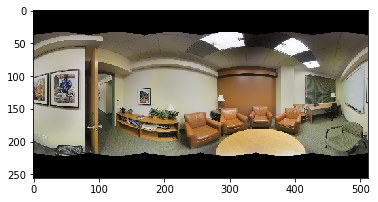

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torchvision.transforms.functional as tfun

path = 'C:/Users/ustundag/Desktop/test_pano_rgb.png'
img = Image.open(path)
img = img.resize((512, 256))
data = np.asarray(img, dtype=np.float32)
data = tfun.to_tensor(data)
data = data.unsqueeze_(0)
data = data[:,:3,:,:]
print(data.shape)
plt.imshow(img)
plt.show()

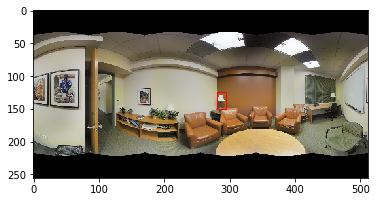

In [8]:
from matplotlib.patches import Rectangle

fig,ax = plt.subplots(1)
ax.imshow(img)
rect = Rectangle((280,125),15,25,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [9]:
# input feature maps is 32x16(x,y) for 512x256 and
#                    is 16x8 (x,y) for 256x128 input image
ratio = 32/512
x_min = np.ceil(280*ratio)
y_min = np.ceil(125*ratio)
x_max = np.ceil(295*ratio)
y_max = np.ceil(150*ratio)
# rois arguments = (batch_index, x_min, y_min, x_max, y_max)
rois = torch.FloatTensor([[0, y_min, x_min, y_max, x_max]])

spheremodel.eval()
preds = spheremodel(data.cuda(), rois.cuda())
print(preds.shape)

torch.Size([1, 1000])


In [10]:
with open('imagenet_classes.txt') as f:
  labels = [line.strip() for line in f.readlines()]

_, index = torch.max(preds, 1)
percentage = torch.nn.functional.softmax(preds, dim=1)[0] * 100 
#print(labels[index[0]], percentage[index[0]].item())

_, indices = torch.sort(preds, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

[('743, prison', 46.25776290893555),
 ('536, dock', 44.141319274902344),
 ('628, liner', 6.562823295593262),
 ('818, spotlight', 1.1813716888427734),
 ('718, pier', 0.9732613563537598)]